# Лабораторная работа № 4. Латентное размещение Дирихле

In [2]:
import numpy as np
import pandas as pd

В этой лабораторной работе мы будем работать со [сценариями кинофильмов на английском языке](https://www.kaggle.com/jrobischon/wikipedia-movie-plots)

Загрузите данные и положите их в ту же папку, что и ноутбук с заданием.

In [3]:
rawdata = pd.read_csv("wiki_movie_plots_deduped.csv")

Прежде чем строить тематическую модель, нужно подготовить данные. Сейчас документы выглядят вот так:

In [3]:
for plot in rawdata.Plot.sample(2):
    print(plot, "\n")

Entrepreneur C. K. Oberoi, who is known for his philandering ways is in love with a judge's daughter and wants to remarry after a failed marriage with his first wife, now old. (Amrish Puri) raises a child as his own as it was his love child, and the child Vijay Kumar (Ajay Devgn) grows to live up to his expectations, but soon has to face the ire of the envious and power hungry relatives of Oberoi, who do not want Vijay to prosper, little knowing that he is in fact a long lost relative or love child of Mr C.K, Oberoi. This film was never a hit. 

Paramasivam, a farmer who lives with his wife Meenakshi and three children in Thanjavur, finds life difficult. Unable to face the difficulties, he goes to Colombo without informing his wife, and joins a drama troupe there. One of his children dies and Meenakshi is harassed by people. She tries to kill the other two children along with herself by jumping into a river with the children. However, they are saved by a sadhu (ascetic). In Colombo, Pa

В тематической модели LDA порядок слов в документе никак не учитывается, важно лишь какие слова и сколько раз встречались в документе. Поэтому далее для обучения модели мы будем использовать представление текста в виде [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model)

Для начала нужно выкинуть из текстов все лишнее, кроме слов: пунктуацию, числа и т.п. Для этого применим стандартную процедуру [токенизации](https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization): 
* разобьем исходные документы-строки на токены
* отбросим все токены, кроме слов 
* соединим токены-слова обратно в строку, для удобства хранения (списки в Python занимают много памяти)

In [4]:
from nltk.tokenize import word_tokenize

data = rawdata.Plot.apply(lambda x: " ".join(list(filter(str.isalpha, word_tokenize(x.lower())))))

Теперь приведем все слова к начальной форме, чтобы уменьшить размер словаря. Это делается с помощью процедуры [лемматизации](https://en.wikipedia.org/wiki/Lemmatisation)

In [5]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer()

In [6]:
data = data.apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in x.split()]))

Вот как теперь выглядят наши тексты

In [13]:
print(data.sample(1).values[0])

aravind prashanth meet anjali jaya re fall in love at first sight without knowing her background when this two meet anjali tell aravind that she would like to go for a for a week which might lead to a romance for which aravind agrees meanwhile anjali is the daughter of jayachandran livingston the commissioner of police saradha suhasini aravind maintains a cordial acquaintance with both of them not knowing that anjali is their daughter anjali acknowledges them a her parent jayachandran convinces anjali to dispense with this trial romance make a deeper commitment a he find aravind a gentleman aravind convinces anjali mother saradha to support him a her suitor and so saradha make aravind marry anjali


Воспользуемся [библиотекой для визуализации текстовых данных](https://github.com/amueller/word_cloud), чтобы нагляднее посмотреть, из каких слов состоят документы

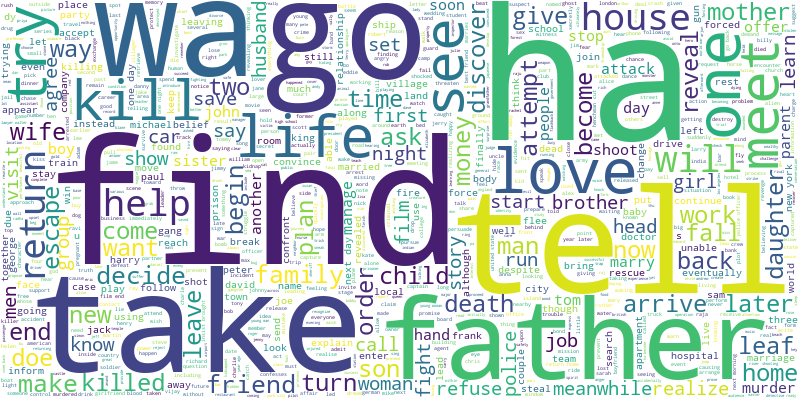

In [16]:
from wordcloud import WordCloud

all_texts = ','.join(list(data.values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, 
                      contour_color='steelblue', width=800, height=400)

wordcloud.generate(all_texts)
wordcloud.to_image()

Теперь создадим bag of words. При его создании мы не будем добавлять в словарь стоп-слова -- служебные части речи, которые присутствуют в подавляющем большинстве текстов, и потому не несут значимой информативной нагрузки

In [7]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english') + ['ha', 'wa'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dmitriygreek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


В стоп-слова добавлены 'ha' и 'wa' потому что в них лемматизатор превращает слова has и was

Воспользуемся [BOW из sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Слова, которые встречаются слишком редко (в небольшом числе документов) мы тоже отбросим, чтобы не перегружать словарь

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
count_vectorizer = CountVectorizer(stop_words=stop_words, min_df=10)
count_data = count_vectorizer.fit_transform(data.values)

Посмотрим на распределение слов в нашем корпусе текстов

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

def plot_most_common_words(count_data, count_vectorizer, n_words):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:n_words]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='Most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=45, fontsize=15) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


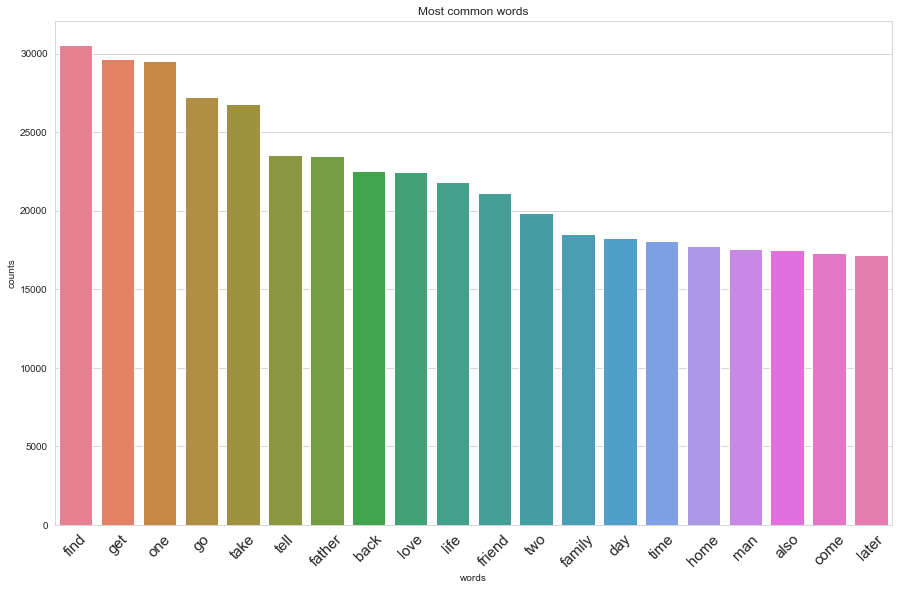

In [11]:
plot_most_common_words(count_data, count_vectorizer, 20)

## Стандартная модель LDA

Теперь приступим к обучению модели. Для начала обучим стандартную модель LDA.

**Задание 1**

Изучите [модель LDA из sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) и обучите её на подготовленных данных. Посмотрите на распределения слов в темах, выведите наиболее вероятные слова для каждой темы

Вспомагательная функция для визуализации самых вероятных слов в темах:

In [12]:
def print_topics(count_vectorizer, phi_matrix, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(phi_matrix):
        print("\nTopic #{}".format(topic_idx))
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [13]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=8, random_state=0)

res = lda.fit_transform(count_data)

In [14]:
print_topics(count_vectorizer, lda.components_, 10)


Topic #0
jack harry peter find tell tommy mary jane return take

Topic #1
king one fight kill son however life men take father

Topic #2
kill find one escape group take attack attempt two earth

Topic #3
police get money car go find take joe man one

Topic #4
tom find house back go see tell one jerry home

Topic #5
team war john michael sam men take captain billy german

Topic #6
love get father life family come friend one son take

Topic #7
life friend love tell go new father one home mother


**Задание 2** 

Часто бывает так, что в LDA выделяется одна или несколько тем с общей лексикой -- т.е. со словами, которые часто встречаются в большом количестве документов корпуса. Проанализируйте полученные в LDA темы и найдите в выделенных темах те, в которые собрались слова общей лексики (или покажите, что таких тем нет). Для этого можно, например:
* проанализировать встречаемость каждой темы в документах, посмотреть на среднее/дисперсию/распределение вероятностей каждой темы в корпусе документов
* посмотреть на встречаемость самых частых слов корпуса в темах

In [19]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

In [15]:
res.shape

(34886, 8)

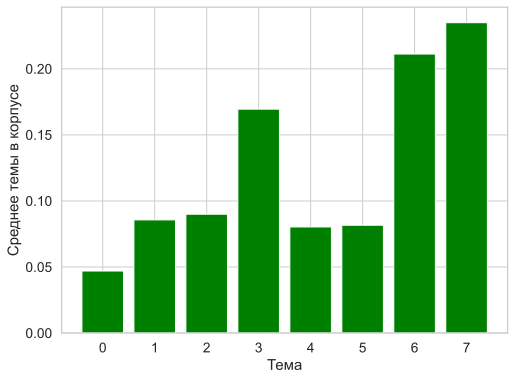

In [24]:
plt.figure(figsize=(8, 6))

plt.bar([i for i in range(res.shape[1])], np.mean(res, axis=0), color='g')

plt.xlabel("Тема")
plt.ylabel("Среднее темы в корпусе")

plt.show()

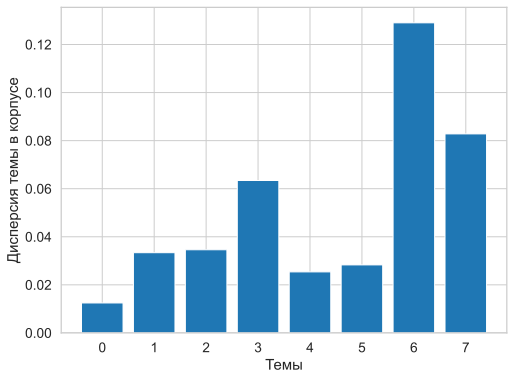

In [22]:
plt.figure(figsize=(8, 6))

plt.bar([i for i in range(res.shape[1])], np.var(res, axis=0))

plt.xlabel("Темы")
plt.ylabel("Дисперсия темы в корпусе")

plt.show()

Видно, что у тем 3, 6 и 7 наибольшие дисперсии и средние значения => можно сказать, что эти темы содержатся в большем числе документов корпуса. Поэтому, можно предположить, что именно в них встречаются слова с общей лексикой.

<ipython-input-29-0765569a10b3>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


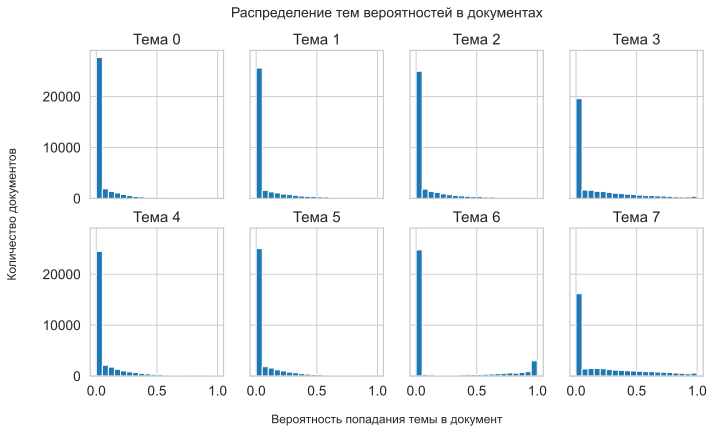

In [29]:
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(11, 6))
fig.suptitle("Распределение тем вероятностей в документах", fontsize=14)
for i in range(8):
    axs[i // 4, i % 4].set_title(f'Тема {i}')
    axs[i // 4, i % 4].hist(res[:, i], bins=20)

fig.supxlabel('Вероятность попадания темы в документ')
fig.supylabel('Количество документов')
fig.show()

Видно, что у тем 3, 6 и 7 вероятности попадания в некоторые документы равна 1. Это подтверждает гипотезу о словах с общей лексикой (также, можно заметить из 1 задания, что в этих темах есть общие слова).

## Упрощенная модель LDA (у каждого документа только одна тема)

Теперь обучим упрощенную модель LDA, разобранную на семинаре. В данной модели одному документу соответсвует одна тема. Вероятностная модель выглядит следующим образом:

Случайные величины:
* $w_{dn}$ -- слово, стоящее на $n$-ой позиции в документе $d$ (наблюдаемая случайная величина)
* $t_d$ -- тема документа $d$ (латентная случайная величина)

Параметры модели:
* $\Phi = \{\phi_{tw}\} \in \mathbb{R}^{T\times V}$ -- матрица распределений слов по темам  ($T$ -- число тем, $V$ -- размер словаря)
* $\pi \in \mathbb{R}^T$ -- вектор распределения тем в корпусе документов 

Совместное распределение на слова в документах и темы документов задается следующим образом:

$p(W, t \;|\; \Phi, \pi) = p(W \;|\; t, \Phi) p(t \;|\; \pi) = \prod_{d=1}^D \prod_{n=1}^{N_d}p(w_{dn}\;|\;t_d, \Phi) p(t_d \;|\; \pi) = \prod_{d=1}^D \prod_{n=1}^{N_d} \phi_{t_d w_{dn}}\pi_{t_d}$

Поскольку в модели присутствуют латентные переменные, оптимизацию параметров мы будем вести с помощью ЕМ-алгоритма:
* **E-шаг:**  $KL(q(t) \;||\; p(t\;|\;\Phi, \pi) ) \to \min_{q(t)}$
* **M-шаг:** $\mathbb{E}_{q(t)} \log p(W, t \;|\; \Phi, \pi) \to \max_{\Phi, \pi}$

**Задание 3**

Выведите формулы для нахождения $q(t_d = t) = \mu_{dt},\;\Phi,\;\pi$ и оптимизируемого функционала ELBO

**Е-шаг**

$$ q\left(t_d = t\right) = p\left(t_d = t \mid w_d\right) = \frac{p\left(t_d = t, w_d\right)}{\sum_{i=1}^T p\left(t_d = i, w_d\right)} = \frac{\pi_t \prod_{n=1}^{N_d} \phi_{t, w_{dn}}}{\sum_{i=1}^T \pi_i \prod_{n=1}^{N_d} \phi_{i, w_{dn}}} $$

**M-шаг**

$$ \mathbb{E}_{q(t)} \log p(W, t \;|\; \Phi, \pi) = \mathbb{E}_{q(t)} \sum_{d=1}^D \sum_{k=1}^T \left[ k = t_d \right] \left(\log \pi_k + \sum_{n=1}^{N_d} \sum_{w=1}^W \left[w_{dn} = w\right]\log\Phi_{kw} \right) = \sum_{d=1}^D \sum_{k=1}^T \mu_{dk} \left(\log \pi_k + \sum_{n=1}^{N_d} \sum_{w=1}^W \left[w_{dn} = w\right]\log\Phi_{kw} \right) $$

* $\pi$

$$ L = \sum_{d=1}^D \sum_{k=1}^T \mu_{dk} \left(\log \pi_k + \sum_{n=1}^{N_d} \sum_{w=1}^W \left[w_{dn} = w\right]\log\Phi_{kw} \right) + \lambda \left(\sum_{k=1}^T \pi_k - 1 \right)$$

$$ \frac{\partial L}{\partial \pi_k} = \sum_{d=1}^D\frac{\mu_{dk}}{\pi_k} + \lambda = 0 \implies \pi_k = - \frac{\sum_{d=1}^D\mu_{dk}}{\lambda} $$

Подставим $\pi_k$ в уравнение связи:

$$ \sum_{k=1}^T \pi_k = - \frac{\sum_{d=1}^D \sum_{k=1}^T  \mu_{dk}}{\lambda} = 1 \implies \lambda = -D$$

Тогда:

$$ \pi_k = \frac{\sum_{d=1}^D\mu_{dk}}{D} $$

* $\Phi$

$$ L = \sum_{d=1}^D \sum_{k=1}^T \mu_{dk} \left(\log \pi_k + \sum_{n=1}^{N_d} \sum_{w=1}^W \left[w_{dn} = w\right]\log\Phi_{kw} \right) + \sum_{k=1}^T \lambda_k \left(\sum_{w=1}^W \Phi_{kw} - 1 \right) $$ 

$$ \frac{\partial L}{\partial \Phi_{kw}} = \frac{\sum_{d=1}^D \mu_{dk} \sum_{n=1}^{N_d} \left[w_{dn} = w\right]}{\Phi_{kw}} + \lambda_k = 0  \implies \Phi_{kw} = -\frac{\sum_{d=1}^D  \mu_{dk}\sum _{n=1}^{N_d} \left[w_{dn} = w\right]}{\lambda_k}$$

Подставим $\Phi_{kw}$ в уравнение связи:

$$ \sum_{w=1}^{W}\Phi_{kw} = - \frac{\sum_{w=1}^W\sum_{d=1}^D  \mu_{dk}\sum _{n=1}^{N_d} \left[w_{dn} = w\right]}{\lambda_k} = 1 \implies \lambda_k = - \sum_{w=1}^W\sum_{d=1}^D  \mu_{dk}\sum _{n=1}^{N_d} \left[w_{dn} = w\right] = - \sum_{d=1}^D N_d \mu_{dk}$$ 

Тогда:

$$ \Phi_{kw} = \frac{\sum_{d=1}^D  \mu_{dk}\sum _{n=1}^{N_d} \left[w_{dn} = w\right]}{\sum_{d=1}^D N_d \mu_{dk}} $$

**ELBO**

$$ ELBO = \mathbb{E}_{q(t)} \log \frac{p(W, t \;|\; \Phi, \pi)}{q(T)} = \sum_{d=1}^D \sum_{k=1}^T \mu_{dk} \left(\log \pi_k + \sum_{n=1}^{N_d} \sum_{w=1}^W \left[w_{dn} = w\right]\log\Phi_{kw} - \log \mu_{dk} \right) $$

**Задание 4**

Реализуйте упрощенный LDA

**Подсказка:** Если вам нужно будет посчитать $\log Softmax$, лучше воспользуйтесь устойчивым способом подсчета из второй практической работы:

$$\alpha_i = \log{p_i(\dots)} \quad\rightarrow \quad
	\frac{e^{\alpha_i}}{\sum_k e^{\alpha_k}} = 
	\frac{e^{(\alpha_i - \max_j \alpha_j)}}{\sum_k e^{(\alpha_k- \max_j \alpha_j)}}$$

In [105]:
class SimpleLDA(object):
    def __init__(self, n_topics, epsilon=1e-15, tol=1e-5):
        self.n_topics = n_topics
        self.epsilon = epsilon
        self.tol = tol
        
    def fit(self, bow, verbose=True):
        self._initialize(bow)
        elbo = -np.inf
        for it in range(1000):
            self._e_step(bow)
            self._m_step(bow)
            new_elbo = self._count_elbo(bow)
            diff = new_elbo - elbo
            if verbose:
                print("\n{}:\n elbo: {}\n increase: {}".format(it, new_elbo, diff))
            if diff < self.tol:
                break
            elbo = new_elbo
            
    
    def _initialize(self, bow):
        V = bow.shape[1]
        self.mu = None
        self.pi = np.abs(np.random.randn(self.n_topics))
        self.pi = self.pi / self.pi.sum()
        self.phi = np.abs(np.random.randn(self.n_topics, V))
        self.phi = self.phi / self.phi.sum(axis=1)[:, np.newaxis]
        
    def _e_step(self, bow):
        self.mu = bow @ ((np.log(self.phi + self.epsilon)).T) + np.log(self.pi + self.epsilon)[np.newaxis, :]
        
        tmp = np.exp(self.mu - np.max(self.mu, axis=1)[:, np.newaxis])
        
        self.mu = tmp / np.sum(tmp, axis=1)[:, np.newaxis]
        
    def _m_step(self, bow):
        self.pi = (self.mu).mean(axis=0)
        
        self.phi = self.mu.T @ bow
        self.phi = self.phi / np.sum(self.phi, axis=1)[:, np.newaxis]
        
    def _count_elbo(self, bow):
        elbo = np.sum(self.mu * (np.log(self.pi) + bow.dot(np.log(self.phi + self.epsilon).T) - np.log(self.mu + self.epsilon)))

        return elbo

**Задание 5**

Обучите упрощенный LDA и посмотрите на самые вероятные слова в каждой теме. Насколько различные получились темы? Насколько интерпретируемые? Сравните их с темами, полученными в классической модели LDA. 

In [103]:
lda_simple = SimpleLDA(8)
lda_simple.fit(count_data)


0:
 elbo: -56152693.244374
 increase: inf

1:
 elbo: -55916050.50481189
 increase: 236642.7395621091

2:
 elbo: -55528641.69799464
 increase: 387408.80681724846

3:
 elbo: -55245348.5207921
 increase: 283293.1772025451

4:
 elbo: -55181813.15606807
 increase: 63535.36472402513

5:
 elbo: -55157450.21155512
 increase: 24362.944512948394

6:
 elbo: -55144289.56492251
 increase: 13160.646632611752

7:
 elbo: -55134958.604425006
 increase: 9330.960497505963

8:
 elbo: -55129245.07103592
 increase: 5713.533389084041

9:
 elbo: -55125635.21179993
 increase: 3609.859235994518

10:
 elbo: -55122047.68093094
 increase: 3587.530868984759

11:
 elbo: -55119606.96690111
 increase: 2440.7140298336744

12:
 elbo: -55117681.94764521
 increase: 1925.0192558988929

13:
 elbo: -55115855.30822338
 increase: 1826.6394218280911

14:
 elbo: -55114208.75625487
 increase: 1646.5519685149193

15:
 elbo: -55113352.22890901
 increase: 856.5273458585143

16:
 elbo: -55112462.905261405
 increase: 889.323647603392


136:
 elbo: -55099577.09786058
 increase: 0.055816881358623505

137:
 elbo: -55099576.88872638
 increase: 0.20913419872522354

138:
 elbo: -55099574.651686385
 increase: 2.2370399981737137

139:
 elbo: -55099556.382683024
 increase: 18.269003361463547

140:
 elbo: -55099555.83241417
 increase: 0.5502688512206078

141:
 elbo: -55099555.43301015
 increase: 0.39940401911735535

142:
 elbo: -55099555.15495189
 increase: 0.278058260679245

143:
 elbo: -55099554.7559619
 increase: 0.3989899903535843

144:
 elbo: -55099538.46376149
 increase: 16.292200408875942

145:
 elbo: -55099535.89621659
 increase: 2.567544899880886

146:
 elbo: -55099526.80136193
 increase: 9.094854660332203

147:
 elbo: -55099523.264518954
 increase: 3.536842979490757

148:
 elbo: -55099517.84515976
 increase: 5.419359192252159

149:
 elbo: -55099517.54639377
 increase: 0.29876599460840225

150:
 elbo: -55099517.27947636
 increase: 0.2669174075126648

151:
 elbo: -55099517.016231276
 increase: 0.2632450833916664

152:


266:
 elbo: -55099383.28689551
 increase: 0.00026126205921173096

267:
 elbo: -55099383.28661777
 increase: 0.00027774274349212646

268:
 elbo: -55099383.28632225
 increase: 0.0002955198287963867

269:
 elbo: -55099383.2860079
 increase: 0.00031434744596481323

270:
 elbo: -55099383.28567396
 increase: 0.0003339424729347229

271:
 elbo: -55099383.28531971
 increase: 0.00035425275564193726

272:
 elbo: -55099383.28494468
 increase: 0.0003750249743461609

273:
 elbo: -55099383.28454863
 increase: 0.00039605051279067993

274:
 elbo: -55099383.28413159
 increase: 0.0004170462489128113

275:
 elbo: -55099383.283693865
 increase: 0.0004377216100692749

276:
 elbo: -55099383.283236295
 increase: 0.00045756995677948

277:
 elbo: -55099383.28276004
 increase: 0.00047625601291656494

278:
 elbo: -55099383.28226691
 increase: 0.0004931315779685974

279:
 elbo: -55099383.28175928
 increase: 0.0005076304078102112

280:
 elbo: -55099383.28124003
 increase: 0.0005192458629608154

281:
 elbo: -550993

In [106]:
print_topics(count_vectorizer, lda_simple.phi, 10)


Topic #0
find one kill take escape back ship two earth go

Topic #1
find go one back tell house take get tom home

Topic #2
one take find two kill back war men return escape

Topic #3
find one take kill back go tell two man later

Topic #4
love get father life family one come friend go take

Topic #5
go get tell find one take new father love friend

Topic #6
find police get take one go kill back two man

Topic #7
tom jerry take tell get go back two house find


Сложно сказать, что все темы получились различными (к примеру, темы 3 и 4), а их интерпретация не такая простая, как в классической модели LDA, от части из-за того, что слова пересекаются.


**Задание 6**

У упрощенной модели LDA могли возникнуть проблемы из-за слов общей лексики. Попробуйте отбросить из словаря слова, которые встречаются больше, чем в 10% документов и обучить упрощенный LDA на этих данных. Посмотрите на получившиеся темы. Как они отличаются от тем модели, обученной на словаре с общей лексикой? Чем объясняются эти различия? Почему у стандартной модели LDA возникает меньше проблем со словами общей лексики?

In [107]:
count_vectorizer_2 = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.1)
count_data_2 = count_vectorizer_2.fit_transform(data.values)

In [108]:
simple_lda_2 = SimpleLDA(8)
simple_lda_2.fit(count_data_2)


0:
 elbo: -43611318.1416981
 increase: inf

1:
 elbo: -43443275.60871901
 increase: 168042.53297908604

2:
 elbo: -43304993.93449178
 increase: 138281.67422723025

3:
 elbo: -43176794.83128668
 increase: 128199.1032050997

4:
 elbo: -43047980.444642395
 increase: 128814.3866442889

5:
 elbo: -42939636.7247896
 increase: 108343.71985279769

6:
 elbo: -42874695.732198484
 increase: 64940.99259111285

7:
 elbo: -42828104.26977858
 increase: 46591.46241990477

8:
 elbo: -42791352.30506447
 increase: 36751.9647141099

9:
 elbo: -42767936.32135055
 increase: 23415.983713917434

10:
 elbo: -42752433.526564345
 increase: 15502.794786207378

11:
 elbo: -42741009.67651679
 increase: 11423.850047551095

12:
 elbo: -42731667.153515816
 increase: 9342.523000977933

13:
 elbo: -42722824.677748606
 increase: 8842.475767210126

14:
 elbo: -42718178.3994897
 increase: 4646.278258904815

15:
 elbo: -42715093.424320236
 increase: 3084.975169464946

16:
 elbo: -42712493.77638878
 increase: 2599.647931456


137:
 elbo: -42685924.218467504
 increase: 2.5528166592121124

138:
 elbo: -42685908.86829123
 increase: 15.350176274776459

139:
 elbo: -42685899.672221
 increase: 9.196070231497288

140:
 elbo: -42685899.57030002
 increase: 0.1019209772348404

141:
 elbo: -42685899.46443024
 increase: 0.10586977750062943

142:
 elbo: -42685899.255887926
 increase: 0.20854231715202332

143:
 elbo: -42685898.87083445
 increase: 0.38505347818136215

144:
 elbo: -42685898.6356556
 increase: 0.2351788505911827

145:
 elbo: -42685898.582136564
 increase: 0.05351903289556503

146:
 elbo: -42685898.508949846
 increase: 0.0731867179274559

147:
 elbo: -42685898.27849712
 increase: 0.23045272380113602

148:
 elbo: -42685896.99407405
 increase: 1.2844230756163597

149:
 elbo: -42685893.09557384
 increase: 3.8985002040863037

150:
 elbo: -42685892.005798906
 increase: 1.0897749364376068

151:
 elbo: -42685870.92311593
 increase: 21.082682974636555

152:
 elbo: -42685860.96304705
 increase: 9.960068881511688

15


267:
 elbo: -42685792.64902457
 increase: 0.018780812621116638

268:
 elbo: -42685792.64285156
 increase: 0.0061730071902275085

269:
 elbo: -42685792.63728451
 increase: 0.005567051470279694

270:
 elbo: -42685792.63194639
 increase: 0.005338117480278015

271:
 elbo: -42685792.62681122
 increase: 0.005135171115398407

272:
 elbo: -42685792.621957004
 increase: 0.004854217171669006

273:
 elbo: -42685792.61749038
 increase: 0.004466623067855835

274:
 elbo: -42685792.613505684
 increase: 0.003984697163105011

275:
 elbo: -42685792.610058844
 increase: 0.00344683974981308

276:
 elbo: -42685792.60715329
 increase: 0.0029055550694465637

277:
 elbo: -42685792.60473504
 increase: 0.0024182498455047607

278:
 elbo: -42685792.60268913
 increase: 0.0020459070801734924

279:
 elbo: -42685792.60081445
 increase: 0.001874685287475586

280:
 elbo: -42685792.59870631
 increase: 0.0021081343293190002

281:
 elbo: -42685792.59522292
 increase: 0.003483392298221588

282:
 elbo: -42685792.5853936
 i


399:
 elbo: -42685276.39533817
 increase: 0.01076933741569519

400:
 elbo: -42685276.389865816
 increase: 0.005472354590892792

401:
 elbo: -42685276.38583378
 increase: 0.004032038152217865

402:
 elbo: -42685276.38177153
 increase: 0.004062250256538391

403:
 elbo: -42685276.37679332
 increase: 0.004978209733963013

404:
 elbo: -42685276.36980733
 increase: 0.006985984742641449

405:
 elbo: -42685276.3587617
 increase: 0.011045634746551514

406:
 elbo: -42685276.339076355
 increase: 0.01968534290790558

407:
 elbo: -42685276.29950945
 increase: 0.03956690430641174

408:
 elbo: -42685276.21236516
 increase: 0.08714429289102554

409:
 elbo: -42685276.03027182
 increase: 0.18209333717823029

410:
 elbo: -42685275.78862169
 increase: 0.24165013432502747

411:
 elbo: -42685275.66812684
 increase: 0.12049484997987747

412:
 elbo: -42685275.63740736
 increase: 0.030719473958015442

413:
 elbo: -42685275.58154677
 increase: 0.05586059391498566

414:
 elbo: -42685275.14837723
 increase: 0.43


529:
 elbo: -42685107.892965555
 increase: 0.049433909356594086

530:
 elbo: -42685107.75821385
 increase: 0.13475170731544495

531:
 elbo: -42685107.376927674
 increase: 0.3812861740589142

532:
 elbo: -42685106.78091912
 increase: 0.5960085541009903

533:
 elbo: -42685106.15646477
 increase: 0.6244543492794037

534:
 elbo: -42685101.662513345
 increase: 4.493951424956322

535:
 elbo: -42685100.7284753
 increase: 0.9340380430221558

536:
 elbo: -42685100.70378513
 increase: 0.0246901735663414

537:
 elbo: -42685100.69865631
 increase: 0.005128815770149231

538:
 elbo: -42685100.69681817
 increase: 0.0018381401896476746

539:
 elbo: -42685100.6958909
 increase: 0.000927269458770752

540:
 elbo: -42685100.69532473
 increase: 0.0005661770701408386

541:
 elbo: -42685100.694922365
 increase: 0.0004023611545562744

542:
 elbo: -42685100.694592185
 increase: 0.00033017992973327637

543:
 elbo: -42685100.694281556
 increase: 0.00031062960624694824

544:
 elbo: -42685100.69394818
 increase: 


657:
 elbo: -42685037.14894118
 increase: 0.0001530572772026062

658:
 elbo: -42685037.14878612
 increase: 0.0001550614833831787

659:
 elbo: -42685037.14862709
 increase: 0.0001590326428413391

660:
 elbo: -42685037.148461595
 increase: 0.00016549229621887207

661:
 elbo: -42685037.14828615
 increase: 0.0001754462718963623

662:
 elbo: -42685037.14809548
 increase: 0.00019066780805587769

663:
 elbo: -42685037.14788074
 increase: 0.00021474063396453857

664:
 elbo: -42685037.14762486
 increase: 0.00025588274002075195

665:
 elbo: -42685037.14728983
 increase: 0.0003350302577018738

666:
 elbo: -42685037.14677023
 increase: 0.0005195960402488708

667:
 elbo: -42685037.14567088
 increase: 0.0010993480682373047

668:
 elbo: -42685037.14154566
 increase: 0.004125222563743591

669:
 elbo: -42685037.089603625
 increase: 0.05194203555583954

670:
 elbo: -42685020.59651941
 increase: 16.493084214627743

671:
 elbo: -42684998.7847189
 increase: 21.81180050969124

672:
 elbo: -42684998.7296460

In [109]:
print_topics(count_vectorizer_2, simple_lda_2.phi, 10)


Topic #0
joe john frank bill jack michael mike sam apartment nick

Topic #1
john tom paul david george play mary peter harry couple

Topic #2
village raja vijay rao ravi college priya rich krishna radha

Topic #3
jack bug charlie gang drug david jimmy gun ray hospital

Topic #4
king power max human castle queen battle army prince book

Topic #5
tom ship war jerry soldier team captain american crew german

Topic #6
singh raj ravi village ajay raju rahul kumar vikram ram

Topic #7
student village gang army master li movie india indian prince


В данном случае темы уже гораздо более интерпретируемыми, так как их проще распознать без лишних слов общей лексики (то есть заносятся слова более узкие для данной темы).

У стандартной модели LDA возникает меньше проблем со словами общей лексики, так как для таких слов создается отдельная тема, а в упрощенном варианте это невозможно, так как есть требование на одну тему для документа.